# Predizione Indice Di Borsa: NASDAQ
## Autori: Luca Morlino e Valerio Di Zio


## Descrizione del problema
### Cos'è NASDAQ?
Il Nasdaq Composite è l'indice azionario statunitense che comprende titoli nazionali e internazionali in cui sono quotate più di 5.200 società. È stato creato nel 1971 con una base di 100.
Le società che compongono l'indice seguono i criteri di capitalizzazione. Il Nasdaq è un indice molto volatile dove sono integrate le più importanti società tecnologiche del mondo.

### Obiettivo
L'obiettivo generale è quello di creare un algoritmo che preveda il valore di chiusura del titolo a inizio giornata.

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
from utility import gain, plot_model_on_data, roi, prepare_data, print_eval

## Estrazione dati
I dati relativi a ^IXIC vengono scaricati dal servizio [Yahoo! Finance](https://it.finance.yahoo.com/).
Per fare ciò viene utilizzata la libreria yfinance che permette l'estrazione di dati in forma di oggetti Python facilmente interrogabili.
In particolare, la usiamo per ottenere i dati storici in forma di Dataframe Pandas.

In [80]:
import yfinance

- Creiamo un oggetto Ticker che rappresenta uno specifico titolo o indice
- Nel nostro caso il simbolo del Nasdaq con il suo valore in dollari è ^IXIC

In [81]:
nasdaq = yfinance.Ticker("^IXIC")

- Utilizziamo il metodo history per ottenere i dati storici, partendo dal 1 Gennaio 2011 fino al 31 Dicembre 2021.

In [82]:
data = nasdaq.history(start="2011-01-02", end="2021-12-31", actions=False)

Ad esempio, guardiamo i dati relativi agli ultimi 5 giorni dell'anno 2021. 

In [83]:
data.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-23,15544.790039,15697.980469,15528.910156,15653.370117,3918200000
2021-12-27,15696.830078,15871.400391,15696.830078,15871.259766,3730120000
2021-12-28,15895.200195,15901.469727,15757.070312,15781.719727,3623600000
2021-12-29,15794.919922,15821.809570,15679.849609,15766.219727,3694500000
2021-12-30,15758.980469,15868.089844,15729.160156,15741.559570,3732730000


Andiamo a contare il numero di istanze ricavate

In [84]:
data.shape[0]

2768

## Features
Il nostro dataset, inizialmente, ha 5 features:
- Open: è il valore in dollari di una singola azione all'orario di apertura
- High: è il valore massimo in dollari raggiunto durante la giornata
- Low: è il valore minimo in dollari raggiunto durante la giornata
- Close: è il valore in dollari di una singola azione all'orario di chiusura
- Volume: il volume di trading indica (nel nostro caso) il valore in dollari delle azioni scambiate durante la giornata

Per comodità estraiamo una serie per ciascuna colonna, per potersi riferire ad esse con un unico nome.

In [85]:
open = data["Open"]
high = data["High"]
low = data["Low"]
close = data["Close"]
volume = data["Volume"]

## Rappresentazione dei dati
Possiamo tracciare il grafico dell'andamento del prezzo, basandoci sulla feature "Open".

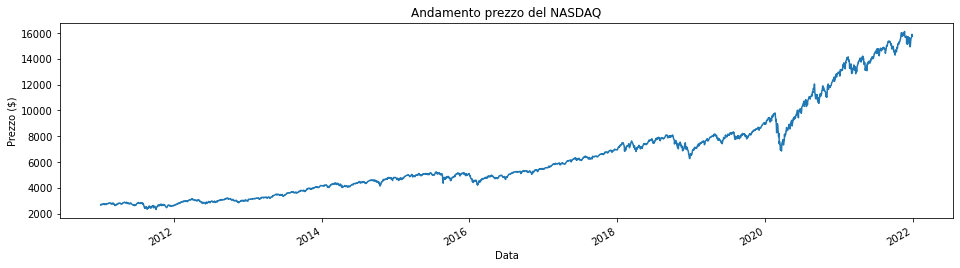

In [86]:
open.plot(figsize=(16,4))
plt.title("Andamento prezzo del NASDAQ")
plt.xlabel("Data")
plt.ylabel("Prezzo ($)");

Utilizzando la libreria plotly è possibile visualizzare in un unico grafico 4 features (Open, High, Low, Close)

In [87]:
import plotly.graph_objects as go

In [88]:
candlestick = go.Candlestick(
                            x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close']
                            )


Il grafico è rappresentato mediante l'utilizzo di Candele, queste ultime rappresentano l'andamento del prezzo di una giornata.

<img src="candlestick.jpeg" alt="Candlestick" style="width:700px;"/>


In [89]:
from ipywidgets.widgets import interact
from datetime import timedelta, datetime

Mostriamo tramite grafico a candele gli ultimi 50 giorni.

In [90]:

termDate = datetime(2021, 12, 31)
DD = timedelta(days=100)
earlier = termDate - DD
earlier_str = earlier.strftime("%Y-%m-%d")

In [91]:
@interact(ymin=(0,13000,500), ymax=(11000,30000,500))
def plot_candlestick(ymin=13000, ymax=17000):    
    fig = go.Figure(data=[candlestick])
    fig.update_layout(
        width=1000, height=700,
        title="Andamento prezzo NASDAQ Candlestick",
        yaxis_title='Prezzo ($)'
    )
    fig.update_xaxes(type="date", range=[earlier_str, termDate])
    fig.update_yaxes(range=[ymin,ymax])
    fig.show()

interactive(children=(IntSlider(value=13000, description='ymin', max=13000, step=500), IntSlider(value=17000, …

Mostriamo ora alcune statistiche generali raggruppate per anno come:
- Media
- Deviazione Standard
- Min e Max
- Quartili


In [92]:
hlm = (high + low) / 2
hlm.groupby(hlm.index.year).describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2011,252.0,2676.244785,122.032911,2352.779907,2604.299988,2693.872559,2776.783752,2873.795044
2012,250.0,2963.932197,113.122627,2640.204956,2894.392517,2975.859985,3050.596283,3187.510010
2013,252.0,3539.060040,306.827311,3089.994995,3243.216248,3492.297485,3777.697510,4169.250000
2014,252.0,4373.320877,211.983366,3997.234985,4202.081360,4355.214966,4535.299988,4806.310059
2015,252.0,4943.834490,157.062179,4493.520020,4838.318787,4984.995117,5069.158813,5216.715088
2016,252.0,4985.242454,297.691485,4251.489990,4759.471130,4951.322510,5239.396118,5490.989990
2017,251.0,6231.484259,394.575343,5425.280029,5885.290161,6239.820068,6491.050049,6989.715088
2018,251.0,7426.148126,367.453986,6272.675049,7146.000122,7394.964844,7732.107544,8101.434814
2019,252.0,7934.295049,471.745590,6528.669922,7678.299988,7964.969971,8194.679871,9019.660156


Guardando i risultati notiamo come i valori della colonna `count` variano a seconda dell'anno, questo accade perché la borsa non è aperta 24/7 ma è chiusa in alcuni giorni, ad esempio i festivi.

Notiamo anche come la media (`mean`) del prezzo aumenta ogni anno, il che rende il NASDAQ un indice solido.

Notiamo anche come nel 2020, l'anno della pandemia, ci sia stata una deviazione standard (`std`) molto alta rispetto agli altri anni.

## Prevedere il valore di chiusura a inizio giornata

La variabile da predire è la features "Close" relativa alla data odierna.

In [93]:
y = close

`high`, `low`, `volume` non possono essere utilizzate in quanto il loro valore non è noto a inizio giornata.
Attualmente l'unica feature utilizzabile è il valore `open`.

In [94]:
features = {"Open" : open}
X = pd.DataFrame(features)

Suddividiamo i dati in un training set e in un validation set con la funzione `train_test_split`.

In [95]:
def split_data(X, y, split):
    lowerRange = X.index.year < split
    upperRange = (X.index.year > split-1) & (X.index.year < split+1)
    X_train = X.loc[lowerRange]
    y_train = y.loc[lowerRange]
    X_val = X.loc[upperRange]
    y_val = y.loc[upperRange]
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = split_data(X, y, 2012)

In [96]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_val, y_val)

0.9522392839582485

In [97]:
delta = close - open

In [98]:
features = {
    "Open": open,
    "OpenShift1": open.shift(1),
    "OpenShift2": open.shift(2),
    "OpenShift3": open.shift(3),
    "OpenShift4": open.shift(4),
}

In [99]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2021)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Gain: 58.50€
 ROI: 0.407%


## Aggiungiamo Features

In [100]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Open']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    df = df.join(MACD)
    
    return df

def calculateSMA(data, ndays): 
    SMA = pd.Series(data['Open'].rolling(ndays).mean(), name = 'SMA') 
    return SMA

def addSMA(first, second):
    sma1 = calculateSMA(data, first)
    sma2 = calculateSMA(data, second)
    
    sma = (np.array(sma2) - np.array(sma1)) / np.array(sma2)
    sma = pd.Series(data=sma, index=data.index)
    data[f"SMA{first}-{second}"] = sma
    features[f"SMA{first}-{second}"] = data[f"SMA{first}-{second}"]
    
    
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

def addEMA(first, second):
    ema1 = calculate_ema(data['Open'], first)
    ema2 = calculate_ema(data['Open'], second)

    ema = (np.array(ema2) - np.array(ema1[(second-first):])) / np.array(ema2)
    ema = pd.Series(data=ema, index=data[(second-1):].index)
    data[f"EMA{first}-{second}"] = ema
    features[f"EMA{first}-{second}"] = data[f"EMA{first}-{second}"]
    
def rsi(close, periods = 14): # il parametro close intende il valore di chiusura del giorno precedente ovvero quello di apertura del giorno corrente
    close_delta = close.diff()
    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

def gainForMFI(x):
    return ((x > 0) * x).sum()

def lossForMFI(x):
    return ((x < 0) * x).sum()

def mfi(high, low, close, volume, n=14): # il parametro close intende il valore di chiusura del giorno precedente ovvero quello di apertura del giorno corrente
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gainForMFI, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(lossForMFI, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

def atr(high, low, close, n=14):
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()

def forceIndex(data, ndays): 
    FI = pd.Series(data['Open'].diff(ndays) * data['Volume'], name = 'ForceIndex') 
    return FI


In [101]:
addEMA(5,20)
addEMA(8,15)
addEMA(20,50)

addSMA(5,20)
addSMA(8,15) #aggiungendo questo indice il guadagno diminuisce negli anni "positivi" e aumenta negli anni "negativi"
addSMA(20,50) #aggiungendo questo indice il guadagno diminuisce negli anni "positivi" e aumenta negli anni "negativi"

data["RSI"] = rsi(data["Open"])
data = computeMACD(data, 12, 26, 9)
data["MFI"] = mfi(data["High"], data["Low"], data["Open"], data["Volume"], 14)
data["ATR"] = atr(data["High"], data["Low"], data["Open"], 14)
data["FI-13"] = forceIndex(data, 13)
data["FI-50"] = forceIndex(data, 13)

features["MACD"] = data["MACD"]
features["RSI"] = data["RSI"] #abbassa i profitti (inutile per ora)
features["MFI"] = data["MFI"] #anche questa sembrerebbe inutile per ora
features["ATR"] = data["ATR"] #STRANO...
features["FI-13"] = data["FI-13"] #assolutamente NO! da risultati orribili (con regressione lineare)
features["FI-50"] = data["FI-50"] #assolutamente NO! da risultati orribili (con regressione lineare)

In [104]:
data["MFI"]

Date
2011-01-03          NaN
2011-01-04          NaN
2011-01-05          NaN
2011-01-06          NaN
2011-01-07          NaN
                ...    
2021-12-23    48.004470
2021-12-27    54.585269
2021-12-28    53.595689
2021-12-29    47.057598
2021-12-30    53.624258
Name: MFI, Length: 2768, dtype: float64

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import itertools

def getBestFeatures(features, model):
    keys = np.array(list(features.keys()))
    mylist = ["1" + "".join(seq) for seq in itertools.product("01", repeat=len(keys)-1)]
    #keys = np.array(['Open', 'OpenShift1', 'OpenShift2', 'OpenShift3','OpenShift4','EMA5-20','EMA8-15','EMA20-50','SMA5-20','SMA8-15','SMA20-50','MACD','RSI','MFI','ATR','FI-13','FI-50'])  
    dict2 = {x:features[x] for x in keys}

    def str2bool(v):
        v_bool = [True]
        for i in v[1:]:
            v_bool.append(i=='1')
        return np.array(v_bool)

    best_ROI = 0;
    best_features = {}

    for i in range(0,len(mylist)):
        dict2 = {x:features[x] for x in keys[str2bool(mylist[i])]}
        X, y = prepare_data(dict2, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, 2021)
        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        if roi(y_val, preds, open) > best_ROI:
            best_ROI = roi(y_val, preds, open)
            best_features = dict2

    return best_features, best_ROI


In [ ]:
import time
start_time = time.time()
new_features, new_ROI = getBestFeatures(features, LinearRegression())
print(new_features)
print(new_ROI)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2021)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Interessante da vedere https://medium.com/codex/this-python-library-will-help-you-get-stock-technical-indicators-in-one-line-of-code-c11ed2c8e45f

In [ ]:
model_a = LinearRegression()
model_a.fit(X_train, y_train)
print_eval(X_val, y_val, model_a, open)

In [ ]:
from sklearn.linear_model import Ridge

model_b = Ridge(alpha=10)
model_b.fit(X_train, y_train)
print_eval(X_val, y_val, model_b, open)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

model_c = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])
model_c.fit(X_train, y_train)
print_eval(X_val, y_val, model_c, open)

Vediamo quanto influiscono i parametri relativi alle colonne

In [ ]:
pd.DataFrame({
    "linear": model_a.coef_,
    "ridge": model_b.coef_,
    "scaled": model_c.named_steps["lr"].coef_
}, index=X.columns)

Con la standardizzazione delle feature otteniamo valori su scale simili, che possiamo confrontare alla pari:
- ad es. negli altri modelli il coefficiente di EMA8-15
  è alto in valore assoluto perché i valori di tale variabile sono bassi 
 - nel modello con standardizzazione assumono invece più peso il numero di stanze (`RM`) e la distanza dagli uffici di collocamento (`DIS`)

In [ ]:
X_train